In [22]:
import os

# 设置 API 密钥和 LangSmith 追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "SQL Agent"  # 为项目命名


In [3]:
import requests

# 下载 Chinook 数据库
url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)
if response.status_code == 200:
    # 将下载的内容保存为 Chinook.db
    with open("../data/Chinook.db", "wb") as file:
        file.write(response.content)
    print("文件已下载并保存为 Chinook.db")
else:
    print(f"文件下载失败，状态码: {response.status_code}")


文件已下载并保存为 Chinook.db


In [5]:
# 导入 SQLDatabase 模块
from langchain_community.utilities import SQLDatabase

# 连接 SQLite 数据库
db = SQLDatabase.from_uri("sqlite:///../data/Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())

# 执行 SQL 查询
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

In [8]:
from langchain_openai import ChatOpenAI

# 初始化用于 SQL 数据库表获取的语言模型（服务于SQLDatabaseToolkit）
sql_llm = ChatOpenAI(model="gpt-4o")

# 初始化用于查询的语言模型（服务于自定义的工具：如 db_query_tool）
query_llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [9]:
from typing import Any
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

# 创建具有回退机制的工具节点
def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    创建一个 ToolNode（工具节点），并为它添加回退机制。回退机制用于
    在工具调用出现错误时处理这些错误，并将错误信息传递给 Agent。
    
    tools: 传入的工具列表，每个工具可以执行某种操作
    返回值: 包含回退逻辑的 ToolNode
    """
    return ToolNode(tools).with_fallbacks(
        # 添加回退逻辑，使用 RunnableLambda 运行 handle_tool_error 方法来处理错误
        [RunnableLambda(handle_tool_error)], 
        # 指定当出现 "error" 时触发回退机制
        exception_key="error"
    )

# 处理工具调用时发生的错误
def handle_tool_error(state) -> dict:
    """
    处理工具调用过程中发生的错误，并返回包含错误信息的消息列表。

    state: 当前的状态，包含工具调用的信息和发生的错误
    返回值: 包含错误信息的消息字典
    """
    # 获取错误信息
    error = state.get("error")
    
    # 获取最后一个消息中的工具调用列表
    tool_calls = state["messages"][-1].tool_calls
    
    # 返回带有错误信息的 ToolMessage 列表
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",  # 生成错误内容
                tool_call_id=tc["id"],  # 记录工具调用的唯一ID
            )
            for tc in tool_calls  # 为每个工具调用创建对应的错误消息
        ]
    }


In [10]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

# 使用数据库连接和 SQL 语言模型创建 SQL 数据库工具包
toolkit = SQLDatabaseToolkit(db=db, llm=sql_llm)

# 从工具包中获取所有可用的工具
tools = toolkit.get_tools()

# 从工具列表中获取用于列出数据库中所有表的工具
list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")

# 从工具列表中获取用于获取指定表的模式（schema）的工具
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

# 调用列出表的工具，并打印输出结果
print(list_tables_tool.invoke(""))

# 调用获取 "Artist" 表模式的工具，并打印输出结果
print(get_schema_tool.invoke("Artist"))

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

CREATE TABLE "Artist" (
	"ArtistId" INTEGER NOT NULL, 
	"Name" NVARCHAR(120), 
	PRIMARY KEY ("ArtistId")
)

/*
3 rows from Artist table:
ArtistId	Name
1	AC/DC
2	Accept
3	Aerosmith
*/


In [11]:
from langchain_core.tools import tool

# 定义 SQL 查询工具
@tool  # 使用 @tool 装饰器将函数定义为一个工具
def db_query_tool(query: str) -> str:
    """
    对数据库执行 SQL 查询并获取结果。
    如果查询不正确，将返回错误消息，并提示用户重写查询。

    参数：
    query (str): 传入的 SQL 查询字符串

    返回值：
    str: 查询结果或错误信息
    """
    # 使用数据库实例 db 来执行查询，run_no_throw 方法保证即使查询失败也不会抛出异常
    result = db.run_no_throw(query)
    
    # 如果查询没有返回结果，提示错误信息
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    
    # 如果查询成功，返回结果
    return result

# 测试 SQL 查询工具
print(db_query_tool.invoke("SELECT * FROM Artist LIMIT 10;"))  # 执行查询并打印结果

[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]


In [12]:
from langchain_core.prompts import ChatPromptTemplate

# 定义用于检查 SQL 查询错误的系统提示模板
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check."""

# 使用从系统消息和用户消息生成的模板来定义提示
query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system),
     ("placeholder", "{messages}")]
)

# 绑定工具 db_query_tool 到提示中，用于在检查查询后执行 SQL 查询
query_check = query_check_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([db_query_tool], tool_choice="required")



In [13]:
# 测试查询检查工具，提供用户查询并调用
query_check.invoke({"messages": [("user", "SELECT * FROM Artist LIMIT 10;")]})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LItDjIxI9UwwICssDhMC1AVg', 'function': {'arguments': '{"query":"SELECT * FROM Artist LIMIT 10;"}', 'name': 'db_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 229, 'total_tokens': 249}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_25624ae3a5', 'finish_reason': 'stop', 'logprobs': None}, id='run-37b72366-ee2c-452c-901b-4f201c4cd8d3-0', tool_calls=[{'name': 'db_query_tool', 'args': {'query': 'SELECT * FROM Artist LIMIT 10;'}, 'id': 'call_LItDjIxI9UwwICssDhMC1AVg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 229, 'output_tokens': 20, 'total_tokens': 249})

In [15]:
from typing import Annotated, Literal
from langchain_core.messages import AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages

# 定义 Agent 的状态结构，存储消息信息
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# 定义一个新的工作流程图
workflow = StateGraph(State)

# 第一个工具调用的节点：获取数据库中的表信息
def first_tool_call(state: State) -> dict[str, list[AIMessage]]:
    return {
        "messages": [
            AIMessage(
                content="",  # 设置消息内容为空，工具调用会生成实际结果
                tool_calls=[
                    {
                        "name": "sql_db_list_tables",  # 调用的工具名称，获取数据库表
                        "args": {},  # 无参数调用
                        "id": "sql_list_tables",  # 为工具调用生成唯一 ID
                    }
                ],
            )
        ]
    }
    
    
# 检查 SQL 查询是否正确的节点
def model_check_query(state: State) -> dict[str, list[AIMessage]]:
    """
    使用该工具检查 SQL 查询的正确性。
    """
    # 使用 query_check 来检查最后一个消息中的查询是否正确
    return {"messages": [query_check.invoke({"messages": [state["messages"][-1]]})]}

# 将工具节点添加到工作流程
# 第一个工具调用节点：列出表
workflow.add_node("first_tool_call", first_tool_call)  
# 创建回退机制的工具节点：列出表
workflow.add_node("list_tables_tool", create_tool_node_with_fallback([list_tables_tool]))
# 创建回退机制的工具节点：获取表架构
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))

# 根据问题和数据库中的表选择相关表的节点，调用 LLM 来做出决定
model_get_schema = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([get_schema_tool])

# 通过 LLM 决定要使用的表
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)


# 定义最终提交答案的模型
class SubmitFinalAnswer(BaseModel):
    """根据查询结果生成最终答案并提交给用户。"""
    final_answer: str = Field(..., description="The final answer to the user")

# 用于生成 SQL 查询的提示模板
query_gen_system = """You are a SQL expert with a strong attention to detail.

Task:
Given an input question, output a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

You can order the results by a relevant column to return the most interesting examples in the database.
- Never query for all the columns from a specific table, only ask for the relevant columns given the question.
- If you get an error while executing a query, rewrite the query and try again.
- If you get an empty result set, you should try to rewrite the query to get a non-empty result set. 
NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.
- If you have enough information to answer the input question, simply invoke the appropriate tool to submit the final answer to the user.
- DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

If you don't have enough information to generate the SQL query:
- Re-list the schema of the relevant tables to understand the tables and columns in detail.
- Use this schema information to help generate a more accurate SQL query based on the input question.
"""


# 生成查询的提示模板，将生成的 SQL 查询提交到适当的工具
query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
# 将生成的查询传递给最终答案的提交工具
query_gen = query_gen_prompt | ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([SubmitFinalAnswer]  )

In [16]:
# 生成查询的节点，处理生成 SQL 查询的逻辑
def query_gen_node(state: State):
    # 调用 query_gen 来生成 SQL 查询
    message = query_gen.invoke(state)

    # 有时 LLM（大型语言模型）会产生幻觉，错误调用工具。我们需要捕获这些错误并返回相应的错误信息。
    tool_messages = []
    
    # 检查生成的消息中是否有工具调用
    if message.tool_calls:
        # 遍历所有工具调用
        for tc in message.tool_calls:
            # 如果工具调用的名称不是 "SubmitFinalAnswer"，则这是一个错误
            if tc["name"] != "SubmitFinalAnswer":
                # 构建一个错误消息，提示用户仅应调用 SubmitFinalAnswer
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",  # 错误内容
                        tool_call_id=tc["id"],  # 工具调用的唯一 ID
                    )
                )
    else:
        # 如果没有工具调用，工具消息列表为空
        tool_messages = []

    # 返回生成的消息和可能的错误消息，作为字典返回
    return {"messages": [message] + tool_messages}
  
  
  # 将查询生成节点添加到工作流程
workflow.add_node("query_gen", query_gen_node)

# 将查询检查和执行节点添加到工作流程
workflow.add_node("correct_query", model_check_query)  # 检查查询是否正确
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))  # 执行查询



# 定义条件判断，决定工作流程是否继续或结束
def should_continue(state: State) -> Literal[END, "correct_query", "query_gen"]:
    last_message = state["messages"][-1]  # 获取最后一条消息
    if getattr(last_message, "tool_calls", None):  # 如果有工具调用，工作流结束
        return END
    if last_message.content.startswith("Error:"):  # 如果有错误，返回生成查询节点重新生成
        return "query_gen"
    else:
        return "correct_query"  # 如果没有错误，则继续检查查询
      
      
# 设置节点之间的连线，定义工作流程的执行顺序
workflow.add_edge(START, "first_tool_call")  # 开始节点连接到第一个工具调用节点
workflow.add_edge("first_tool_call", "list_tables_tool")  # 调用列出表的工具
workflow.add_edge("list_tables_tool", "model_get_schema")  # 根据问题决定使用哪个表
workflow.add_edge("model_get_schema", "get_schema_tool")  # 获取表的架构
workflow.add_edge("get_schema_tool", "query_gen")  # 根据表架构生成查询
# 根据检查结果决定是否继续
workflow.add_conditional_edges("query_gen", should_continue)  
workflow.add_edge("correct_query", "execute_query")  # 检查查询后执行查询
workflow.add_edge("execute_query", "query_gen")  # 查询执行后，继续生成查询

In [17]:
# 将工作流程编译为可运行的应用
app = workflow.compile()

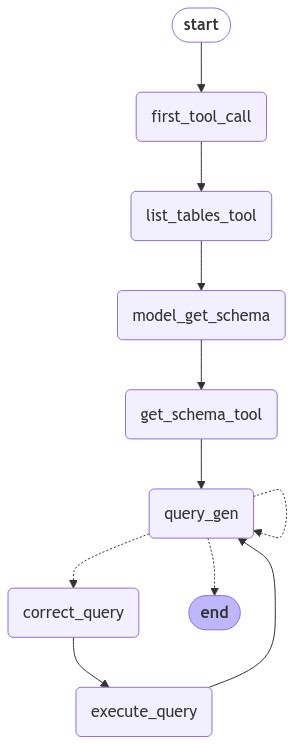

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [23]:
# query = "Which sales agent made the most in sales in 2009?"
# query = "AC/DC所有专辑中的曲目数量?"
query = "发票金额最高的前五个客户的名字和发票总额?"

events = app.stream(
    {"messages": [("user", query)]},
    stream_mode="values"  # stream_mode 设置为 "values"，表示返回流式数据的值
)

# 遍历每个事件，并打印最后一条消息的内容
for event in events:
    # 通过 pretty_print 打印最后一条消息的内容
    event["messages"][-1].pretty_print()

================================ Human Message =================================

发票金额最高的前五个客户的名字和发票总额?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (sql_list_tables)
 Call ID: sql_list_tables
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_OdsACfcreyuxA71OsulwamR9)
 Call ID: call_OdsACfcreyuxA71OsulwamR9
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City